In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pydot
import sys
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
import cvxpy as cvx
from cvxpy import *
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# flow dynamics on the tree
class FlowNetwork:

    def __init__(self,design_list,r_crit):
        self.design_list=design_list
        self.ntiers=len(design_list)
        self.r_crit=r_crit
        self.L=len(design_list)
        G,edges,nodes,n2e=self.make_tree(design_list)
        self.G=G.copy()
        self.edges=edges
        self.nodes=nodes
        self.n2e=n2e
        self.N=len(nodes)
        numberOfInnerNodes=self.sum_nodes_by_layer(design_list[:self.L-1])
        self.topNodes=[i for i in range(self.N) if i >= numberOfInnerNodes]
        self.NT=len(self.topNodes)
        self.NI=self.N-self.NT
        self.node_state=[0]*self.N
        self.A=nx.adjacency_matrix(G)
        self.mincap=self.makeMinCap()
#        print(self.N,len(self.mincap),"self.mincap=",self.mincap)
#        extra=np.zeros(self.N)       
#        extra=.2*(4+np.random.poisson(2,self.N-1))
#        extra=(np.random.uniform(.5,1,self.N-1))
#        extra=np.insert(extra,7,0)
#        self.cap=(extra+self.mincap).flatten()
        mult=np.random.uniform(1.1,1.5,self.N-1)
        mult=np.insert(mult,7,1)
        self.cap=mult*self.mincap.flatten()
        
    def getMinCap(self): return self.mincap.flatten()
    def getCap(self): return self.cap.flatten()
    def setNodeState(self,node_state):
        self.node_state=node_state
    def getNodeState(self):
        return self.node_state
    
    def iterate(self):
        self.node_state = A.dot(self.node_state)

    def sum_nodes_by_layer(self,ns):
        s=0
        for i in range(len(ns)+1):
            s += np.prod(ns[0:i])
        return s

    def custom_tree_edges(self,tiers):
        n,m,M,edges=0,1,1,[(0,0)]
        for t in tiers:
            for i in range(n,M):
                n += 1
                for j in range(t):
                    m+=1
                    e=(m-1,n-1)
                    edges.append(e)
            M=m
        return edges
    
    def printv(self,msg,x,verbose=False): 
        if verbose:
            print(msg,'_'.join([str(int(i)) for i in x]))

    def makeMinCap(self):
        v=False
        x0=np.append(np.zeros(self.NI),self.r_crit+np.ones(self.NT)).reshape((self.N,1));self.printv('',x0.flatten(),v)
        x=x0.copy()
        xi=x0.copy()
        for i in range(self.ntiers):
            xi=self.A.T.dot(xi);self.printv('',xi.flatten(),v)
            x += xi
        return (x.T)

    def make_tree(self,design_list):
        edges=self.custom_tree_edges(design_list)
        G=nx.DiGraph()
        for e in edges:
            G.add_edge(e[0],e[1])
        G.remove_edge(0,0)
        edges=G.edges()
        nodes=G.nodes()
        n2e={}
        for n in nodes:
            for e in edges:
                if e[0]==n:
                    n2e[n]=e
        return([G,edges,nodes,n2e])
    
    def regulateAndOverflow(self,projected_flow_demand):
        projected_flow_demand=projected_flow_demand.flatten()
        regulated_flow_demand=np.array([projected_flow_demand[i] 
                                        if projected_flow_demand[i]<self.cap[i] 
                                        else self.cap[i] 
                                        for i in range(len(projected_flow_demand))])
        overflow=np.array([projected_flow_demand[i]-self.cap[i] 
                     if projected_flow_demand[i]>self.cap[i] 
                     else 0 
                     for i in range(len(projected_flow_demand))])
        return regulated_flow_demand,overflow

    def makeFlowDemand(self,rain):
        input_flow_demand=np.append( np.zeros(self.NI)
                     ,np.ones( self.NT) + rain
                    ).reshape((self.N,1))#;self.printv('',input_flow_demand.flatten(),'False')
        accumulated_overflow=np.zeros(self.N)
        accumulated_regulated_flow_demand=np.zeros(self.N)
        for tier in range(self.ntiers+1):
            regulated_flow_demand_i,overflow_i=self.regulateAndOverflow(input_flow_demand)
            accumulated_regulated_flow_demand += regulated_flow_demand_i
            accumulated_overflow += overflow_i
            input_flow_demand=self.A.T.dot(regulated_flow_demand_i)
        return (accumulated_regulated_flow_demand,accumulated_overflow)

    def reportOverflows(self,r):
        accumulated_regulated_flow_demand, accumulated_overflow=self.makeFlowDemand(r)
        ii=np.where(accumulated_overflow>0)[0]
        ofl=[g for g in accumulated_overflow if g>0 ]
#         print("fn::reportOverflows::accumulated_regulated_flow_demand(r=",r,")="
#              , accumulated_regulated_flow_demand
#              )
#         print("fn::reportOverflows::accumulated_overflow(r=",r,")="
#              , accumulated_overflow
#              )
        
        return (ii,ofl,accumulated_regulated_flow_demand)

In [3]:
def maxent2(fG,totCap,fn,overflow_report,testMe=False):
    verbose=testMe
    estcap = cvx.Variable(fn.N)
    objective = cvx.Maximize(cvx.sum(cvx.entr(estcap)))
    constraints = [0 <= estcap, estcap <= totCap,sum(estcap)==totCap]
    
    #at critical rain:
    constraints.append(estcap >= fn.getMinCap() )
    
    for r in overflow_report.keys():
        ofl_amts=overflow_report[r]['ofl_amts']
        ofl_nodes=overflow_report[r]['ofl_nodes']
        num_ofl_nodes=len(ofl_nodes)
        for i in range(num_ofl_nodes): #overflow constraints
            x=fG.neighbors(ofl_nodes[i])
            parents=[k for k in x if k>ofl_nodes[i]]
            if len(parents)>0: #if internal node
                y=[1]; y.extend([-1]*len(parents)); y=np.array(y)
                yy=[ofl_nodes[i]];yy.extend(parents); yy=np.array(yy)
                if verbose: print("OF: ",y,".",yy,"<=",-ofl_amts[i])
                constraints.append(y @ estcap[yy] <= -ofl_amts[i])#arfd[ofl_nodes[i]])
                #    EC[7]+overflow <= FL[25]+FL[26]+FL[27] < = EC[25]+EC[26]+EC[27]
                #                      --------arfd--------
                #    EC[7]-EC[25]-EC[26]-EC[27] <= -overflow[7]
            else: # if toplevel node
                yy=[ofl_nodes[i]]
                if verbose: print("OF: ",yy,"<=",r+1+ofl_amts[i])
                constraints.append(estcap[ofl_nodes[i]]<=r+1+ofl_amts[i])
        for i in range(fn.N): #non overflow constraints
            if i not in ofl_nodes:
                x=fG.neighbors(i)
                parents=[k for k in x if k>i]
                if len(parents)>0: #no nonoverflow constraints for internal nodes
                    pass # no generalization possible here; not true that est_capacity[i]> sum est_capacity of parents
                else: #toplevel node
                    yy=[i]
                    if verbose: print("normal [1].",yy,">=",r+1)
                    constraints.append(estcap[i]>=r+1)

    constraints.append(estcap[0]<=304)
    constraints.append(estcap[0]>=300)
    #at r2
    prob = cvx.Problem(objective, constraints)
    result = prob.solve()
    if testMe: print(result)
    return(estcap.value)

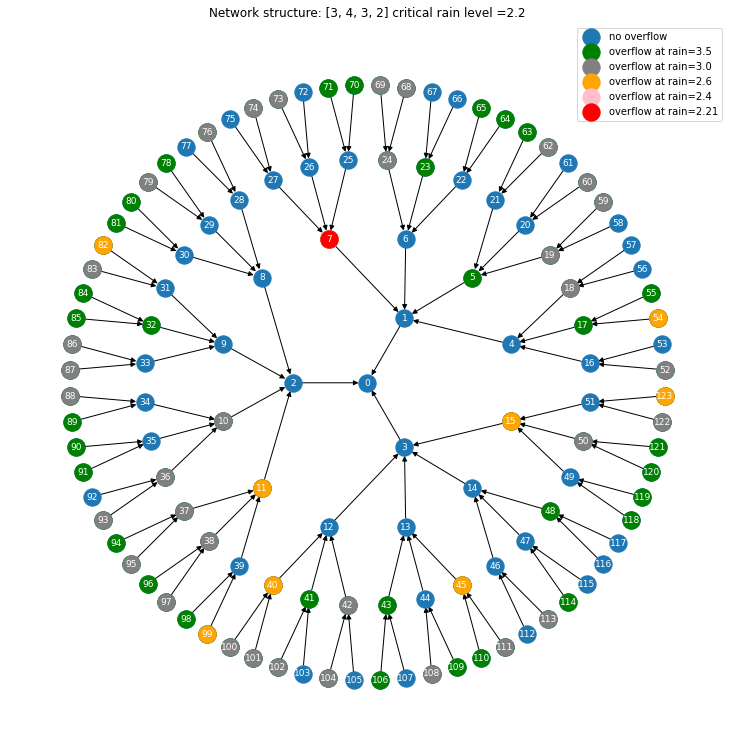

In [24]:
#print("overflow nodes with rain=",r1,":",ofl_nodes2)
#print("overflow amounts with rain=",r1,"ofl=",ofl_amts2)
def showTree(fn,overflow_report,colors):
    pos = graphviz_layout(fn.G, prog="twopi")
    plt.figure(figsize=(10,10))
    nx.draw(fn.G, pos, with_labels=True, font_color="white",font_size=9,label="no overflow")
    for r in sorted(overflow_report.keys(),reverse=True):
        nx.draw_networkx_nodes(fn.G, pos
                               , overflow_report[r]['ofl_nodes']
                               , node_color=colors[r],label="overflow at rain="+str(r))
    #nx.draw_networkx_nodes(G, pos, ofl_nodes3, node_color="gray",label="overflow at rain="+str(r3))
    #nx.draw_networkx_nodes(G, pos, ofl_nodes2, node_color="orange",label="overflow at rain="+str(r2))
    #nx.draw_networkx_nodes(G, pos, ofl_nodes1, node_color="red",label="overflow at rain="+str(r1))
    plt.title("Network structure: "+str(fn.design_list) +" critical rain level ="+str(fn.r_crit))
    plt.legend()
    plt.show()
def doAnalysis(protocols):
    fns=[]
    overflow_reports=[]
    for pr in protocols.keys():
        fn=FlowNetwork(protocols[pr]['design_list'],protocols[pr]['r_crit'])
        fns.append(fn)
        overflow_report={}
        for r in colors.keys():
            ofl_nodes,ofl_amts,arfd=fn.reportOverflows(r)
            overflow_report[r]={}
            overflow_report[r]['ofl_nodes']=ofl_nodes
            overflow_report[r]['ofl_amts']=ofl_amts
            overflow_report[r]['arfd']=arfd
        overflow_reports.append(overflow_report)
        showTree(fn,overflow_report,protocols[pr]['colors'])
    return overflow_reports,fns


#######################


protocols={}

##
protocols[1]={}
colors={}
colors[2.21]="red"
colors[2.4]="pink"
colors[2.6]="orange"
colors[3.0]="gray"
colors[3.5]="green"
protocols[1]["colors"]=colors
protocols[1]["design_list"]=[3,4,3,2]
protocols[1]["r_crit"]=2.2

if False:
    colors={}
    colors[2.21]="red"
#    colors[2.6]="orange"
    colors[3.0]="gray"
    colors[3.5]="green"
    protocols[2]={}
    protocols[2]["colors"]=colors
    protocols[2]["design_list"]=[3,4,3,2]
    protocols[2]["r_crit"]=2.2
#protocol[1]["fn"]=
#pr=1
#fn=FlowNetwork(protocols[pr]['design_list'],protocols[pr]['r_crit'])


overflow_reports,fns=doAnalysis(protocols)#fn,colors)


In [25]:
overflow_reports[0][2.21]
fns[0].cap[[7,25,26,27]]
fns[0].cap[7]-fns[0].cap[[25,26,27]].sum() #< -.06



-7.839626924563948

In [26]:
prnum=0
totCap=1.2*np.sum(fns[prnum].mincap)
fG=nx.Graph(fns[prnum].G)
cap_maxent=maxent2(fG,totCap,fns[prnum],overflow_reports[prnum],True)
print("and the answer is . . . \n",cap_maxent)


OF:  [ 1 -1 -1 -1] . [ 7 25 26 27] <= -0.05999999999999517
normal [1]. [52] >= 3.21
normal [1]. [53] >= 3.21
normal [1]. [54] >= 3.21
normal [1]. [55] >= 3.21
normal [1]. [56] >= 3.21
normal [1]. [57] >= 3.21
normal [1]. [58] >= 3.21
normal [1]. [59] >= 3.21
normal [1]. [60] >= 3.21
normal [1]. [61] >= 3.21
normal [1]. [62] >= 3.21
normal [1]. [63] >= 3.21
normal [1]. [64] >= 3.21
normal [1]. [65] >= 3.21
normal [1]. [66] >= 3.21
normal [1]. [67] >= 3.21
normal [1]. [68] >= 3.21
normal [1]. [69] >= 3.21
normal [1]. [70] >= 3.21
normal [1]. [71] >= 3.21
normal [1]. [72] >= 3.21
normal [1]. [73] >= 3.21
normal [1]. [74] >= 3.21
normal [1]. [75] >= 3.21
normal [1]. [76] >= 3.21
normal [1]. [77] >= 3.21
normal [1]. [78] >= 3.21
normal [1]. [79] >= 3.21
normal [1]. [80] >= 3.21
normal [1]. [81] >= 3.21
normal [1]. [82] >= 3.21
normal [1]. [83] >= 3.21
normal [1]. [84] >= 3.21
normal [1]. [85] >= 3.21
normal [1]. [86] >= 3.21
normal [1]. [87] >= 3.21
normal [1]. [88] >= 3.21
normal [1]. [89]

-4498.425528323712
and the answer is . . . 
 [299.99999887  76.79999994  76.79999994  76.79999994  19.20000058
  19.20000058  19.20000058  19.20000048  19.20000058  19.20000058
  19.20000056  19.20000056  19.20000058  19.20000058  19.20000058
  19.20000056   7.01661273   7.01660966   7.01661158   7.01661271
   7.01661483   7.01661483   7.01661273   7.01661219   7.01661166
   8.33342856   8.33342856   8.33342856   7.01661273   7.01661273
   7.01661273   7.01661273   7.01661104   7.01661273   7.1559493
   7.1559493    7.15594763   7.02877842   7.0287803    7.02876176
   7.01662468   7.01661175   7.01661076   7.01661182   7.01661273
   7.01662453   7.01661273   7.01661273   7.01661214   7.13875248
   7.13875131   7.13875248   4.38413865   7.01661352   3.67911582
   4.60719298   7.01661494   7.01661494   7.01661632   4.2223845
   4.25257441   7.01661352   4.08031109   4.69117214   4.78577614
   4.83348727   7.01661416   7.01661416   4.10934439   4.06992788
   4.77944201   4.9206607    7.01

In [27]:
def maxent(totCap,fn,overflow_report):
    estcap = cp.Variable(fn.N)
    objective = cp.Maximize(cp.sum(cp.entr(estcap)))
    constraints = [0 <= estcap, estcap <= totCap,sum(estcap)==totCap]
    
    #at critical rain:
    for i in range(fn.N):
        constraints.append(estcap[i]>=fn.getMinCap()[i])
        
    for r in overflow_report.keys():
        ofl_nodes=overflow_report[r]['ofl_nodes']
        arfd=overflow_report[r]['arfd']
        for i in range(len(ofl_nodes)):
            constraints.append(estcap[ofl_nodes[i]]<=arfd[ofl_nodes[i]])
        for i in range(len(ofl_nodes)):
            if i not in ofl_nodes:
                constraints.append(estcap[i]>=arfd[i])

    constraints.append(estcap[0]<=304)
    constraints.append(estcap[0]>=300)
    #at r2

    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    #print(estcap.value)
    return(estcap.value)

#totCap=1.2*np.sum(fn.mincap)
#cap_maxent=maxent2(totCap,fn,overflow_report)
#plt.scatter(cap_maxent,fn.cap)
#plt.plot([0,300],[0,300])
#np.sqrt(np.mean((cap_maxent-fn.cap)**2))
# think about staging the tiers so that tier 3 <= .5 * tier 2
# tier 1 is the plant
#cap_maxent


In [28]:
totMinCap=np.sum(fns[prnum].mincap)
print(totMinCap)
totCap=totMinCap
prnum=0
mults=[]
rmses=[]
for multiplier in np.linspace(1,1.5,51):
    
    
    fG=nx.Graph(fns[prnum].G)

    mults.append(multiplier)
    totCap=totMinCap*multiplier
    cap_maxent=maxent2(fG,totCap,fns[prnum],overflow_reports[prnum],False)
    #print(cap_maxent)
    if cap_maxent is not None:
  #           np.sqrt(np.mean((cap_maxent-fn.cap)**2))
        rmse=np.sqrt(np.mean((fns[prnum].cap-cap_maxent)**2))
        print("mult=",multiplier,"totcap=",totCap, "rmse=",rmse)
        rmses.append(rmse)
    else:
        print("None for totcap=",totCap)
        rmses.append(None)

1151.9999999999998
None for totcap= 1151.9999999999998
None for totcap= 1163.5199999999998
None for totcap= 1175.0399999999997
None for totcap= 1186.5599999999997
None for totcap= 1198.0799999999997
None for totcap= 1209.6
None for totcap= 1221.12
None for totcap= 1232.6399999999999
None for totcap= 1244.1599999999999
None for totcap= 1255.6799999999998
None for totcap= 1267.1999999999998
None for totcap= 1278.7199999999998
mult= 1.12 totcap= 1290.2399999999998 rmse= 3.996523764129975
mult= 1.13 totcap= 1301.7599999999995 rmse= 3.997410238727246
mult= 1.1400000000000001 totcap= 1313.28 rmse= 3.9997855988140962
mult= 1.15 totcap= 1324.7999999999997 rmse= 4.004195549155659
mult= 1.16 totcap= 1336.3199999999997 rmse= 4.013894066846561
mult= 1.17 totcap= 1347.8399999999997 rmse= 4.036443472152866
mult= 1.18 totcap= 1359.3599999999997 rmse= 4.061406731803905
mult= 1.19 totcap= 1370.8799999999997 rmse= 4.05815197482559
mult= 1.2 totcap= 1382.3999999999996 rmse= 4.061172326022488
mult= 1.21 t

1.12

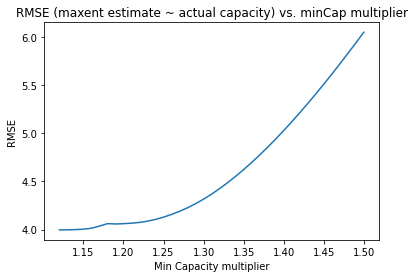

In [30]:
plt.plot(mults,rmses)
plt.xlabel("Min Capacity multiplier")
plt.ylabel("RMSE")
plt.title("RMSE (maxent estimate ~ actual capacity) vs. minCap multiplier")
df=pd.DataFrame(zip(mults,rmses))
df=df.dropna(axis=0)
df.reset_index()
df.columns=["mult","RMSE"]
#np.where(df['mult'].to_array()==np.min(df['mult'].to_array()))
mults=[i for i in df['mult']]
rmses=[i for i in df['RMSE']]
i=np.where(rmses==np.min(rmses))[0][0]
mult_min=mults[i]
mult_min
#rmses